# CH.4.4 선형판별분석(Linear Discriminant Analysis)

## **수업목표**
1.
### Confusion Matrix 이해
2.
### LDA, QDA, (+Baysian Classifier) 에 대한 이해와 실습
---

# 혼동행렬(Confusion Matrix)

**Confusion Matrix는 정확도(accuracy), 정밀도(precision), 재현율(recall) 등을 측정할 수 있는 테이블**

T : Truth 참
F : False 허위, 거짓
P : Positive 양성
N : Negative 음성

TP(True Positive): True를 True로 잘 예측한 것

TN(True Negative): False를 False로 잘 예측한 것

FP(False Positive): False를 True로 잘 못 예측한 것

FN(False Negative): True를 False로 잘 못 예측한 것

---

정확도=True를 True로, Flase를 False로 잘 예측했는가?
$$accuracy=\frac{TP+TN}{TP+TN+FP+FN}$$

* 100,000개 데이터 중 99,900개 정상거래, 100개 사기 거래인 경우 = 정확도 : 99.9% 

but, 우리가 관심이 있는 부분은 100개의 사기 거래에 대한 예측. 이 경우 정확도는 적절한 평가지표가 아님

---

정밀도= True로 예측한 값들 중에서 정말로 예측한 값이 맞는가?
$$precision=\frac{TP}{TP+FP}$$
* 정밀도가 상대적으로 더 중요한 지표인 경우 실제 False인 데이터 예측을 Positive로 잘못 판단(허위 음성)하게 되면 큰 불이익이 발생하는 경우
* 정밀도와 재현율은 서로 상충관계인 경우가 많음
* 예를 들어, 임계값을 높게 설정하면 정밀도는 증가하지만 재현율은 감소함
---

특이도(Type 1 error) = 잘못 예측한 비율 중 실제로 거짓인데 positive이라고 예측한 비율
$$fallout=\frac{FP}{FP+TN}$$
---

민감도,재현율 = 잘 예측한 클래스 중 실제로 참인데 positive로 예측한 비율
$$recall=\frac{TP}{TP+FN}$$
* 재현율(recall), 민감도(sensitivity), TPR(True Positive Rate)라고 불림.
* 1-TPR = type 2 error -> 특히 중요할 수 있음

---

F1 Score 정밀도와 재현율은 상호 보완할 수 있는 수준에서 적용돼야 합니다. 그렇지 않고 단순히 하나의 성능 지표 수치를 높이기 위한 수단으로 사용해서는 안 됩니다. 정밀도와 재현율을 결합한 지표를 F1 Score라고 합니다. F1 Score는 정밀도와 재현율이 어느 한쪽으로 치우치지 않는 수치를 나타낼 때 상대적으로 높은 값을 가집니다.
$$F_{1} Score=2 \times \frac{(precision\times recall)}{precision+recall}$$

* 파이썬 - sklearn.metrics에서 classification_report 메소드 이용하면 쉽게 구할 수 있음.

정밀도와 재현율의 가중조화평균(weight harmonic average)을 F점수(F-score)라고 한다. 정밀도에 주어지는 가중치를 베타(beta)라고 한다.

Fβ=(1+β2)(precision×recall)/(β2precision+recall)
베타가 1인 경우를 특별히 F1점수라고 한다.

F1=2⋅precision⋅recall/(precision+recall)
사이킷런 패키지의 metrics 패키지에서는 정밀도, 재현율, F1점수를 구하는 classification_report 명령을 제공한다. 이 명령은 각각의 클래스를 양성(positive) 클래스로 보았을 때의 정밀도, 재현율, F1점수를 각각 구하고 그 평균값으로 전체 모형의 성능을 평가한다.

# package import

In [179]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.datasets import make_classification

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import MultinomialNB


from sklearn.metrics import classification_report

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# data import

In [180]:
url = 'https://raw.githubusercontent.com/RAhyunki/dataset/main/Default.csv' # github에 있는 raw파일 로드
Default = pd.read_csv(url) # credit dataframe에 저장
print(Default.shape)
print(Default.head())

(10000, 4)
  default student      balance        income
0      No      No   729.526495  44361.625074
1      No     Yes   817.180407  12106.134700
2      No      No  1073.549164  31767.138947
3      No      No   529.250605  35704.493935
4      No      No   785.655883  38463.495879


In [181]:
Default['default'] = pd.Series(np.where(Default.default.values == 'Yes', 1, 0), Default.index)
Default['student'] = pd.Series(np.where(Default.student.values == 'Yes', 1, 0), Default.index)
Default.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   default  10000 non-null  int32  
 1   student  10000 non-null  int32  
 2   balance  10000 non-null  float64
 3   income   10000 non-null  float64
dtypes: float64(2), int32(2)
memory usage: 234.5 KB


In [182]:
Default.head()

,default,student,balance,income
0,0,0,729.526495,44361.625074
1,0,1,817.180407,12106.134700
2,0,0,1073.549164,31767.138947
3,0,0,529.250605,35704.493935
4,0,0,785.655883,38463.495879


In [183]:
X = np.array(Default.iloc[:, 1:3])
y = np.array(Default.iloc[:, 0:1])

# LDA / QDA / MultinomialNB(다항정규분포-베이즈분류)

# LDA

In [187]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [188]:
lda = LinearDiscriminantAnalysis()

In [189]:
lda.fit(X, y)

C:\Users\ahdal\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


LinearDiscriminantAnalysis()

In [190]:
#X_transform = lda.fit(X, y).transform(X)
y_predict = lda.fit(X, y).predict(X)

C:\Users\ahdal\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [191]:
metrics.accuracy_score(y, y_predict)

0.9725

In [192]:
## Confusion matrix
confusion_matrix(y,lda.predict(X))

array([[9644,   23],
       [ 252,   81]], dtype=int64)

In [193]:
cunfmat = pd.DataFrame(confusion_matrix(y, y_predict),
                        index=['True[No]','True[Yes]',],
                        columns=['Predict[NO]', 'Predict[Yes]']) # 순서가 중요
cunfmat

,Predict[NO],Predict[Yes]
True[No],9644,23
True[Yes],252,81


In [194]:
from sklearn.metrics import classification_report

print(classification_report(y, y_predict))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      9667
           1       0.78      0.24      0.37       333

    accuracy                           0.97     10000
   macro avg       0.88      0.62      0.68     10000
weighted avg       0.97      0.97      0.97     10000



# QDA

In [195]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda=QuadraticDiscriminantAnalysis()
qda.fit(X, y)

C:\Users\ahdal\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


QuadraticDiscriminantAnalysis()

In [196]:
y_predict = qda.fit(X, y).predict(X)

C:\Users\ahdal\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [197]:
## Confusion matrix
confusion_matrix(y,qda.predict(X))

array([[9637,   30],
       [ 244,   89]], dtype=int64)

In [198]:
cunfmat = pd.DataFrame(confusion_matrix(y, y_predict),
                        index=['True[No]','True[Yes]',],
                        columns=['Predict[NO]', 'Predict[Yes]']) # 순서가 중요
cunfmat

,Predict[NO],Predict[Yes]
True[No],9637,30
True[Yes],244,89


In [199]:
from sklearn.metrics import classification_report

print(classification_report(y, y_predict))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      9667
           1       0.75      0.27      0.39       333

    accuracy                           0.97     10000
   macro avg       0.86      0.63      0.69     10000
weighted avg       0.97      0.97      0.97     10000



# NB

In [200]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB(alpha=1, fit_prior=True)

In [201]:
nb.fit(X,y)

C:\Users\ahdal\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


MultinomialNB(alpha=1)

In [205]:
y_predict = nb.predict(X)

In [209]:
## Confusion matrix
sum(nb.predict(X)==y)/len(y) ## 0.8222222222222222
confusion_matrix(y, nb.predict(X))

array([[9667,    0],
       [ 333,    0]], dtype=int64)

In [211]:
cunfmat = pd.DataFrame(confusion_matrix(y, y_predict),
                        index=['True[No]','True[Yes]',],
                        columns=['Predict[NO]', 'Predict[Yes]']) # 순서가 중요
cunfmat

,Predict[NO],Predict[Yes]
True[No],9667,0
True[Yes],333,0


# 시각화

In [212]:
from sklearn.datasets import make_classification

In [213]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

model = LinearDiscriminantAnalysis().fit(X, y)
y_hat = model.predict(X)
f_value = model.decision_function(X)

C:\Users\ahdal\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [218]:
confusion_matrix(y, y_hat, labels=[1, 0])

array([[  81,  252],
       [  23, 9644]], dtype=int64)

In [219]:
recall = 81 / (81 + 252)
fallout = 1- 23 / (23 + 9644)
print("recall =", recall)
print("fallout =", fallout)

recall = 0.24324324324324326
fallout = 0.9976207716975277


In [220]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y, model.decision_function(X))
fpr, tpr, thresholds

(array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.03444709e-04,
        1.03444709e-04, 2.06889418e-04, 2.06889418e-04, 3.10334126e-04,
        3.10334126e-04, 4.13778835e-04, 4.13778835e-04, 6.20668253e-04,
        6.20668253e-04, 7.24112962e-04, 7.24112962e-04, 8.27557670e-04,
        8.27557670e-04, 9.31002379e-04, 9.31002379e-04, 1.03444709e-03,
        1.03444709e-03, 1.13789180e-03, 1.13789180e-03, 1.24133651e-03,
        1.24133651e-03, 1.55167063e-03, 1.55167063e-03, 1.65511534e-03,
        1.65511534e-03, 1.75856005e-03, 1.75856005e-03, 1.96544947e-03,
        1.96544947e-03, 2.06889418e-03, 2.06889418e-03, 2.17233888e-03,
        2.17233888e-03, 2.27578359e-03, 2.27578359e-03, 2.37922830e-03,
        2.37922830e-03, 2.58611772e-03, 2.58611772e-03, 2.68956243e-03,
        2.68956243e-03, 2.79300714e-03, 2.79300714e-03, 3.10334126e-03,
        3.10334126e-03, 3.41367539e-03, 3.41367539e-03, 3.51712010e-03,
        3.51712010e-03, 3.62056481e-03, 3.62056481e-03, 3.724009

In [221]:
#fpr, tpr, thresholds = roc_curve(y, model.predict_proba(X)[:, 1])
#fpr, tpr, thresholds

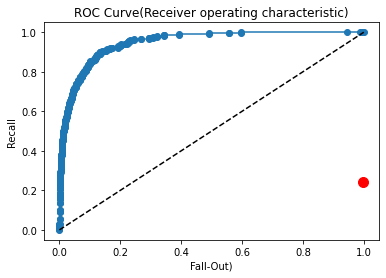

In [222]:
import matplotlib.pyplot as plt
plt.plot(fpr, tpr, 'o-', label="lda")
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([fallout], [recall], 'ro', ms=10)
plt.xlabel('Fall-Out)')
plt.ylabel('Recall')
plt.title('ROC Curve(Receiver operating characteristic)')
plt.show()

In [223]:
from sklearn.datasets import make_classification

model1 = LinearDiscriminantAnalysis().fit(X, y)
y_hat1 = model1.predict(X)

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
model2 = QuadraticDiscriminantAnalysis().fit(X, y)
y_hat2 = model2.predict(X)

from sklearn.naive_bayes import GaussianNB
model3 = GaussianNB().fit(X,y)
y_hat3 = model3.predict(X)

from sklearn.naive_bayes import MultinomialNB # 다변량가우스분포
model4 = MultinomialNB().fit(X,y)
y_hat4 = model4.predict(X)

C:\Users\ahdal\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\ahdal\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\ahdal\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\ahdal\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

In [224]:
#from sklearn.naive_bayes import BernoulliNB
#model3 = BernoulliNB(alpha=2).fit(X,y)
#y_hat3 = model3.predict(X)

In [225]:
print(confusion_matrix(y, y_hat1))

[[9644   23]
 [ 252   81]]


In [226]:
print(confusion_matrix(y, y_hat2))

[[9637   30]
 [ 244   89]]


In [227]:
print(confusion_matrix(y, y_hat3))

[[9618   49]
 [ 238   95]]


In [228]:
print(confusion_matrix(y, y_hat4))

[[9667    0]
 [ 333    0]]


In [229]:
print(classification_report(y, model1.predict(X)))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      9667
           1       0.78      0.24      0.37       333

    accuracy                           0.97     10000
   macro avg       0.88      0.62      0.68     10000
weighted avg       0.97      0.97      0.97     10000



In [230]:
print(classification_report(y, model2.predict(X)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      9667
           1       0.75      0.27      0.39       333

    accuracy                           0.97     10000
   macro avg       0.86      0.63      0.69     10000
weighted avg       0.97      0.97      0.97     10000



In [231]:
print(classification_report(y, model3.predict(X)))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      9667
           1       0.66      0.29      0.40       333

    accuracy                           0.97     10000
   macro avg       0.82      0.64      0.69     10000
weighted avg       0.97      0.97      0.97     10000



In [232]:
print(classification_report(y, model4.predict(X)))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      9667
           1       0.00      0.00      0.00       333

    accuracy                           0.97     10000
   macro avg       0.48      0.50      0.49     10000
weighted avg       0.93      0.97      0.95     10000



C:\Users\ahdal\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


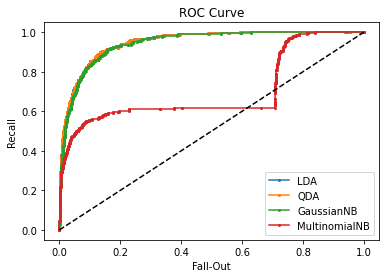

In [233]:
fpr1, tpr1, thresholds1 = roc_curve(y, model1.decision_function(X))
fpr2, tpr2, thresholds1 = roc_curve(y, model2.decision_function(X))
fpr3, tpr3, thresholds1 = roc_curve(y, model3.predict_proba(X)[:, 1]) # NB는 decision_function 메서드를 제공하지 않는 모형임. 따라서 확률 따로 입력해주어야함.
fpr4, tpr4, thresholds1 = roc_curve(y, model4.predict_proba(X)[:, 1]) # NB는 decision_function 메서드를 제공하지 않는 모형임. 따라서 확률 따로 입력해주어야함.

plt.plot(fpr1, tpr1, 'o-', ms=2, label="LDA")
plt.plot(fpr2, tpr2, 'o-', ms=2, label="QDA")
plt.plot(fpr3, tpr3, 'o-', ms=2, label="GaussianNB")
plt.plot(fpr4, tpr4, 'o-', ms=2, label="MultinomialNB")


plt.legend()
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Fall-Out')
plt.ylabel('Recall')
plt.title('ROC Curve')
plt.show()

In [234]:
from sklearn.metrics import auc
auc(fpr1, tpr1), auc(fpr2, tpr2), auc(fpr3, tpr3), auc(fpr4, tpr4)

(0.9495584339900053, 0.9495317185396838, 0.9446511785396651, 0.701788164496347)